In [1]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
import os 
import pandas as pd
import plotly.graph_objs as go
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
import glob

In [3]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count

In [4]:
train_dir ="/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
test_dir="/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]='0,1'

In [6]:
train_samples =get_files(train_dir)
num_classes=len(glob.glob(train_dir+"/*"))
test_samples=get_files(test_dir)
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

38 Classes
70295 Train images
17572 Test images


In [7]:
from keras.preprocessing.image import ImageDataGenerator

In [8]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [9]:
img_width,img_height =384,384
input_shape=(img_width,img_height,3)
batch_size =32
train_generator =train_datagen.flow_from_directory(train_dir,
                                target_size=(img_width,img_height),                                                    batch_size=batch_size)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,target_size=(img_width,img_height),                                               batch_size=batch_size)


Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [10]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras
from keras import optimizers
model_finetuned = Sequential()

model_finetuned.add(ResNet50(include_top=False, weights='imagenet', input_shape=(384,384,3)))
model_finetuned.add(BatchNormalization())
model_finetuned.add(GlobalAveragePooling2D())
model_finetuned.add(Dense(128, activation="relu"))
model_finetuned.add(Dense(38, activation="softmax"))
for layer in model_finetuned.layers[0].layers:
  if layer.__class__.__name__=="BatchNormalization":
    layer.trainable=True
  else:
    layer.trainable=False
model_finetuned.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

94773248/94765736 [==============================] - 1s 0us/step


In [11]:
model_finetuned.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 12, 12, 2048)      23587712  
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 2048)      8192      
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 38)                4902      
Total params: 23,863,078
Trainable params: 324,390
Non-trainable params: 23,538,688
_________________________________________________________________


In [12]:
"""
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras
from keras import optimizers
model_finetuned = ResNet50(include_top=False, weights='imagenet', input_shape=(384,384,3))
x = model_finetuned.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
predictions = Dense(38, activation="softmax")(x)
model_finetuned = Model(inputs=model_finetuned.input, outputs=predictions)
model_finetuned.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
model_finetuned.summary()
"""

'\nfrom keras.applications.resnet50 import ResNet50\nfrom keras.models import Model\nimport keras\nfrom keras import optimizers\nmodel_finetuned = ResNet50(include_top=False, weights=\'imagenet\', input_shape=(384,384,3))\nx = model_finetuned.output\nx = GlobalAveragePooling2D()(x)\nx = Dense(128, activation="relu")(x)\npredictions = Dense(38, activation="softmax")(x)\nmodel_finetuned = Model(inputs=model_finetuned.input, outputs=predictions)\nmodel_finetuned.compile(optimizer=\'adam\',\n                  loss = \'categorical_crossentropy\',\n                  metrics=[\'accuracy\'])\nmodel_finetuned.summary()\n'

In [13]:
from keras.callbacks import ReduceLROnPlateau

In [14]:
validation_generator = train_datagen.flow_from_directory(
                       test_dir, # same directory as training data
                       target_size=(img_height, img_width),
                       batch_size=batch_size)

Found 17572 images belonging to 38 classes.


In [15]:
history_1 = model_finetuned.fit(train_generator,                                    
                                  steps_per_epoch=None, 
                                  epochs=8,validation_data=validation_generator,validation_steps=None
                                  ,verbose=1,callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],use_multiprocessing=False,
               shuffle=True)

Epoch 1/8
2197/2197 [==============================] - 3419s 2s/step - loss: 0.4250 - accuracy: 0.8946 - val_loss: 0.0383 - val_accuracy: 0.9868
Epoch 2/8
2197/2197 [==============================] - 3011s 1s/step - loss: 0.0353 - accuracy: 0.9881 - val_loss: 0.0235 - val_accuracy: 0.9921
Epoch 3/8
2197/2197 [==============================] - 3000s 1s/step - loss: 0.0246 - accuracy: 0.9911 - val_loss: 0.0229 - val_accuracy: 0.9922
Epoch 4/8
2197/2197 [==============================] - 3111s 1s/step - loss: 0.0219 - accuracy: 0.9929 - val_loss: 0.0251 - val_accuracy: 0.9921
Epoch 5/8
2197/2197 [==============================] - 3160s 1s/step - loss: 0.0186 - accuracy: 0.9937 - val_loss: 0.0304 - val_accuracy: 0.9923
Epoch 6/8
2197/2197 [==============================] - 3161s 1s/step - loss: 0.0166 - accuracy: 0.9942 - val_loss: 0.0239 - val_accuracy: 0.9929
Epoch 7/8
2197/2197 [==============================] - 3039s 1s/step - loss: 0.0102 - accuracy: 0.9969 - val_loss: 0.0074 - val_ac

In [16]:
print("teja")

teja


In [17]:
from keras.models import load_model
model_finetuned.save('plantddusingresnet50of8epochs.h5')


In [18]:
from keras.models import load_model
model=load_model('plantddusingresnet50of8epochs.h5')


[[8.6843195e-28 6.5930568e-37 8.0858851e-27 2.6134960e-24 1.2509153e-18
  6.0211308e-18 7.7633013e-23 4.3873130e-24 3.8068988e-30 5.0570752e-23
  3.0601117e-20 6.5825575e-28 1.7079791e-26 6.7336538e-26 2.2529008e-28
  3.2657990e-18 1.1443858e-31 3.8949770e-30 1.2487135e-24 7.2865306e-21
  1.9216537e-24 1.5407600e-26 1.6110490e-25 1.5801187e-16 1.8394905e-24
  4.3566951e-23 5.6786824e-26 5.3044669e-21 1.7940155e-17 2.0792422e-20
  4.5499341e-17 1.9992922e-18 5.3239030e-23 2.3197117e-21 8.8185481e-22
  1.0000000e+00 2.6676769e-24 1.3072225e-18]]


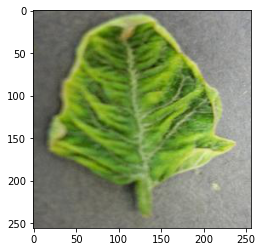

In [19]:
classes=list(train_generator.class_indices.keys())
import numpy as np
import matplotlib.pyplot as plt
# Pre-Processing test data same as train data.
img_width=256
img_height=256
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
from keras.preprocessing import image
def prepare(img_path):
    img = image.load_img(img_path, target_size=(384,384))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
    
result = model.predict([prepare('/kaggle/input/new-plant-diseases-dataset/test/test/TomatoYellowCurlVirus6.JPG')])

disease=image.load_img('/kaggle/input/new-plant-diseases-dataset/test/test/TomatoYellowCurlVirus6.JPG')
plt.imshow(disease)
print(result)

In [20]:
import numpy as np
classresult=np.argmax(result,axis=1)
print(classes[classresult[0]])

Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [24]:
import tensorflow as tf
keras_model = tf.keras.models.load_model("plantddusingresnet50of8epochs.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)

In [26]:
model = converter.convert()
file = open( 'outputresnet50of8epoch.tflite' , 'wb' ) 
file.write( model )

95059832

In [27]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="outputresnet50of8epoch.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print("")
print(output_details)

[{'name': 'resnet50_input', 'index': 0, 'shape': array([  1, 384, 384,   3], dtype=int32), 'shape_signature': array([ -1, 384, 384,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]

[{'name': 'Identity', 'index': 193, 'shape': array([ 1, 38], dtype=int32), 'shape_signature': array([-1, 38], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [28]:
def prepare(img_path):
    img = image.load_img(img_path, target_size=(384,384))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
    
input_data = [prepare('/kaggle/input/new-plant-diseases-dataset/test/test/TomatoYellowCurlVirus6.JPG')]

In [29]:
input_shape = input_details[0]['shape']
interpreter.set_tensor(input_details[0]['index'], input_data[0])

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[8.6843532e-28 6.5930568e-37 8.0859160e-27 2.6134960e-24 1.2508770e-18
  6.0210622e-18 7.7632717e-23 4.3873470e-24 3.8069278e-30 5.0570367e-23
  3.0600884e-20 6.5825820e-28 1.7079726e-26 6.7337056e-26 2.2529182e-28
  3.2658240e-18 1.1444033e-31 3.8950067e-30 1.2487039e-24 7.2865306e-21
  1.9216462e-24 1.5407543e-26 1.6110182e-25 1.5801246e-16 1.8394836e-24
  4.3567115e-23 5.6786824e-26 5.3044265e-21 1.7940427e-17 2.0792501e-20
  4.5499516e-17 1.9992922e-18 5.3238821e-23 2.3197028e-21 8.8186157e-22
  1.0000000e+00 2.6676872e-24 1.3072125e-18]]


In [30]:
classresult=np.argmax(output_data,axis=1)
print(classes[classresult[0]])

Tomato___Tomato_Yellow_Leaf_Curl_Virus


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


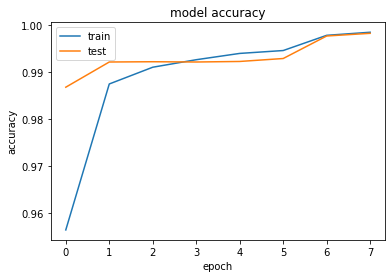

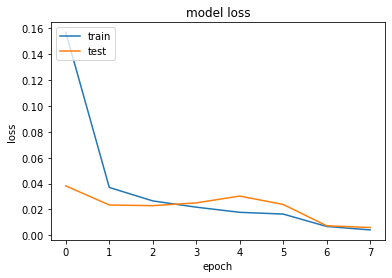

In [31]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

print(history_1.history.keys())

plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()